In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyviper
import os

import scanpy as sc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
    
from scGraphLLM.eval_config import IMMUNE_CELL_TYPES
from scGraphLLM.eval_config import *


REG_VALS = "regulator.values"
TAR_VALS = "target.values"
MI_VALS = "mi.values"
LOGP_VALS = "log.p.values"
SCC_VALS = "scc.values"

MYE_CELL_TYPES = [
    'Macro_C1QC',
    'Mono_CD16',
    'Mono_CD14',
    'cDC2_CD1C',
    'Macro_LYVE1',
    # 'Macro_SPP1',
    'Macro_NLRP3',
    # 'Macro_GPNMB',
    # 'Macro_INHBA',
    # 'Macro_IL1B',
    # 'cDC2_CXCR4hi',
    # 'cDC2_CD1A', # exclude due to insufficient edge count (< 500)
    # 'Macro_FN1',
    # 'pDC_LILRA4',
    # 'cDC2_IL1B',
    # 'cDC2_FCN1',
    # 'Macro_ISG15',
    # 'cDC3_LAMP3',
    # 'cDC2_CXCL9',
    # 'cDC1_CLEC9A',
    # 'cDC2_ISG15'
]


In [6]:
cells_path_format = "/hpc/mydata/rowan.cassius/data/scGPT/mye/all/cell_type/{}/cells.h5ad"

In [7]:
cells_list = []
for cell_type in MYE_CELL_TYPES:
    cells_path = cells_path_format.format(cell_type)
    cells = sc.read_h5ad(cells_path)
    # if cells.n_obs > n:
    #     sc.pp.subsample(cells, n_obs=n, random_state=12345, copy=False)
    cells_list.append(cells)

In [8]:
adata = ad.concat(cells_list, join='outer', axis=0)

In [10]:
sc.tl.pca(adata, svd_solver='arpack', random_state=12345)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

Text(0.5, 1.0, 'Myeloid Dataset')

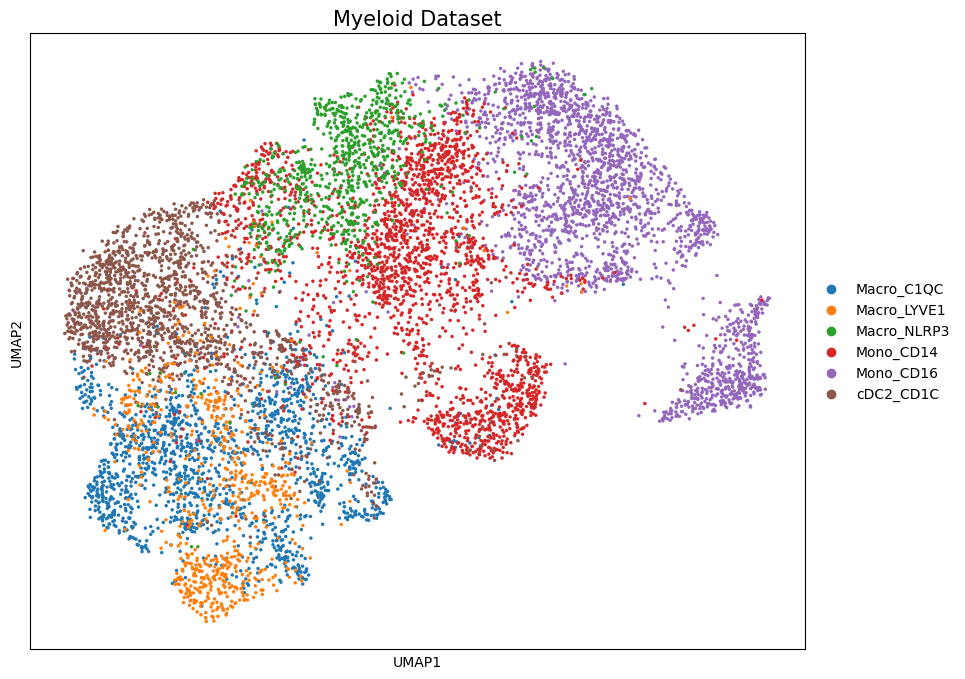

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
sc.pl.umap(adata, color="cell_type", ax=ax, size=25, show=False)
ax.set_title("Myeloid Dataset", fontsize=15)

Text(0.5, 1.0, 'Myeloid Dataset')

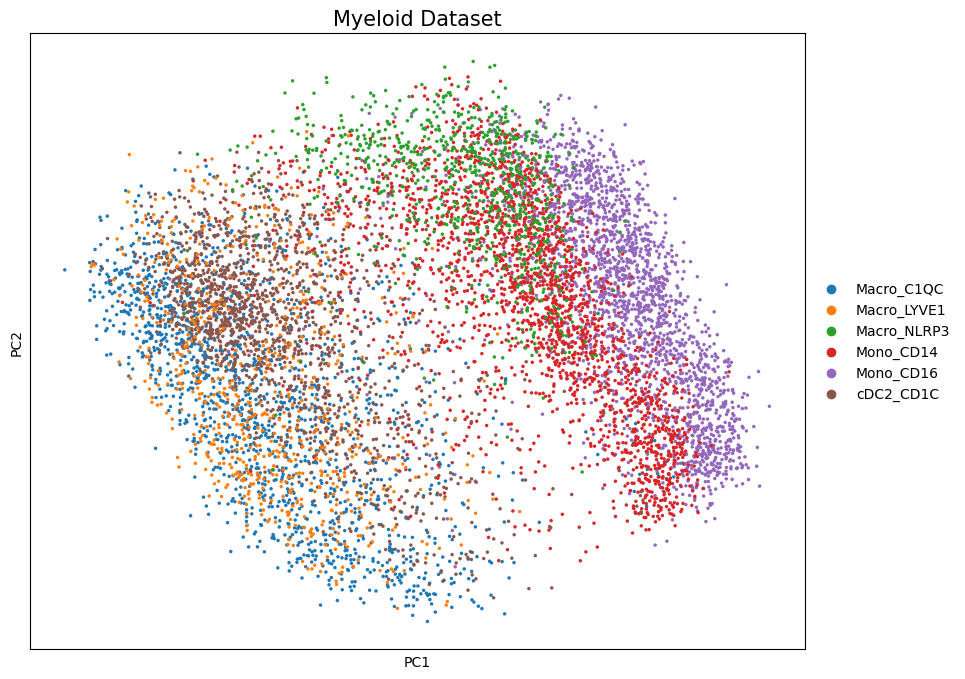

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
sc.pl.pca(adata, color="cell_type", ax=ax, size=25, show=False)
ax.set_title("Myeloid Dataset", fontsize=15)

In [ ]:
mye_split = SPLIT_CONFIGS["mye"]
mye_split

{'metadata_config': ('cancer_type', (None, None, ['MYE', 'OV-FTC', 'ESCA'])),
 'ratio_config': (0.85, 0.15, None)}

In [19]:
test_cancer_types = mye_split["metadata_config"][1][2]
test_cancer_types

['MYE', 'OV-FTC', 'ESCA']

In [20]:
test_mask = adata.obs['cancer_type'].isin(test_cancer_types)

In [24]:
test = adata[test_mask,:]
train = adata[~test_mask,:]

In [25]:
test

View of AnnData object with n_obs × n_vars = 2860 × 2662
    obs: 'cell_type', 'cancer_type', 'batch', 'set', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'sample_id', 'cluster'
    uns: 'pca', 'neighbors', 'umap', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [26]:
train

View of AnnData object with n_obs × n_vars = 6401 × 2662
    obs: 'cell_type', 'cancer_type', 'batch', 'set', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'sample_id', 'cluster'
    uns: 'pca', 'neighbors', 'umap', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [35]:
X_train = train.obsm["X_pca"]
y_train = train.obs["cell_type"]
X_test = test.obsm["X_pca"]
y_test = test.obs["cell_type"]

In [36]:
for k in (5,10,15,20,25,30,35,40,45,50):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn.fit(X_train, y_train)
    ytest_pred = knn.predict(X_test)

    # Evaluate
    print(f"Accuracy for {k} neighbors:", round(accuracy_score(y_test, ytest_pred), 4))

    # pd.DataFrame(classification_report(y_test, ytest_pred, output_dict=True)).T

Accuracy for 5 neighbors: 0.75
Accuracy for 10 neighbors: 0.7521
Accuracy for 15 neighbors: 0.7556
Accuracy for 20 neighbors: 0.7538
Accuracy for 25 neighbors: 0.7587
Accuracy for 30 neighbors: 0.7542
Accuracy for 35 neighbors: 0.7531
Accuracy for 40 neighbors: 0.7524
Accuracy for 45 neighbors: 0.7493
Accuracy for 50 neighbors: 0.75


In [37]:
k=25
knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn.fit(X_train, y_train)
ytest_pred = knn.predict(X_test)

# Evaluate
print(f"Accuracy for {k} neighbors:", round(accuracy_score(y_test, ytest_pred), 4))

pd.DataFrame(classification_report(y_test, ytest_pred, output_dict=True)).T

Accuracy for 25 neighbors: 0.7587


,precision,recall,f1-score,support
Macro_C1QC,0.821767,0.651250,0.726639,800.000000
Macro_LYVE1,0.400000,0.359375,0.378601,256.000000
Macro_NLRP3,0.774074,0.590395,0.669872,354.000000
Mono_CD14,0.684592,0.944365,0.793765,701.000000
Mono_CD16,0.962617,0.950185,0.956360,542.000000
cDC2_CD1C,0.763393,0.826087,0.793503,207.000000
accuracy,0.758741,0.758741,0.758741,0.758741
macro avg,0.734407,0.720276,0.719790,2860.000000
weighted avg,0.766956,0.758741,0.753286,2860.000000


In [32]:
ytrain_pred = knn.predict(X_train)

# Evaluate
print("Accuracy:", accuracy_score(y_train, ytrain_pred))

pd.DataFrame(classification_report(y_train, ytrain_pred, output_dict=True)).T

Accuracy: 1.0


,precision,recall,f1-score,support
Macro_C1QC,1.0,1.0,1.0,792.0
Macro_LYVE1,1.0,1.0,1.0,447.0
Macro_NLRP3,1.0,1.0,1.0,454.0
Mono_CD14,1.0,1.0,1.0,1619.0
Mono_CD16,1.0,1.0,1.0,1721.0
cDC2_CD1C,1.0,1.0,1.0,1368.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,6401.0
weighted avg,1.0,1.0,1.0,6401.0


In [38]:
X = adata.obsm["X_pca"]
X_probs = knn.predict_proba(X)  # shape: (n_cells, n_classes)
X_train_probs = knn.predict_proba(X_train)
X_test_probs = knn.predict_proba(X_test)

# View class order
print("Class order:", knn.classes_)

Class order: ['Macro_C1QC' 'Macro_LYVE1' 'Macro_NLRP3' 'Mono_CD14' 'Mono_CD16'
 'cDC2_CD1C']


In [39]:
adata.obsm["class_probs"] = X_probs
adata.uns["class_probs_names"] = knn.classes_

In [43]:
adata.obsm["class_probs"].round(3)

array([[0.355, 0.   , 0.   , 0.407, 0.043, 0.196],
       [0.807, 0.039, 0.   , 0.034, 0.   , 0.121],
       [0.121, 0.04 , 0.   , 0.763, 0.   , 0.076],
       ...,
       [0.   , 0.   , 1.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 1.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 1.   , 0.   , 0.   , 0.   ]])

In [45]:
adata.uns["class_probs_names"]

array(['Macro_C1QC', 'Macro_LYVE1', 'Macro_NLRP3', 'Mono_CD14',
       'Mono_CD16', 'cDC2_CD1C'], dtype=object)

In [5]:
import scanpy as sc
save_path = "/hpc/mydata/rowan.cassius/data/scGPT/mye/preprocessed_mye.h5ad"
# adata.write_h5ad(save_path)
adata = sc.read_h5ad(save_path)

In [6]:
network_format = "/hpc/mydata/rowan.cassius/data/scGPT/mye/all/cell_type/{}/aracne_metacells_pruned/consolidated-pruned-no-elim-net_defaultid.tsv"
networks = {cell_type: network_format.format(cell_type) for cell_type in MYE_CELL_TYPES}

In [7]:
networks

{'Macro_C1QC': '/hpc/mydata/rowan.cassius/data/scGPT/mye/all/cell_type/Macro_C1QC/aracne_metacells_pruned/consolidated-pruned-no-elim-net_defaultid.tsv',
 'Mono_CD16': '/hpc/mydata/rowan.cassius/data/scGPT/mye/all/cell_type/Mono_CD16/aracne_metacells_pruned/consolidated-pruned-no-elim-net_defaultid.tsv',
 'Mono_CD14': '/hpc/mydata/rowan.cassius/data/scGPT/mye/all/cell_type/Mono_CD14/aracne_metacells_pruned/consolidated-pruned-no-elim-net_defaultid.tsv',
 'cDC2_CD1C': '/hpc/mydata/rowan.cassius/data/scGPT/mye/all/cell_type/cDC2_CD1C/aracne_metacells_pruned/consolidated-pruned-no-elim-net_defaultid.tsv',
 'Macro_LYVE1': '/hpc/mydata/rowan.cassius/data/scGPT/mye/all/cell_type/Macro_LYVE1/aracne_metacells_pruned/consolidated-pruned-no-elim-net_defaultid.tsv',
 'Macro_NLRP3': '/hpc/mydata/rowan.cassius/data/scGPT/mye/all/cell_type/Macro_NLRP3/aracne_metacells_pruned/consolidated-pruned-no-elim-net_defaultid.tsv'}

In [8]:
class_networks = {
    name: pd.read_csv(path, sep="\t").set_index([REG_VALS, TAR_VALS]) 
    for name, path in networks.items()
}
# classes_hat = adata.uns["class_probs_names"][adata.obsm["class_probs"].argmax(axis=1)]

In [9]:
class_networks

{'Macro_C1QC':                                   scc.values  log.p.values
 regulator.values target.values                            
 ENSG00000001084  ENSG00000180509    0.074779      -3.79567
                  ENSG00000180530    0.085190      -3.79567
                  ENSG00000100321   -0.089160      -3.79567
                  ENSG00000100055    0.026351      -3.79567
                  ENSG00000100368   -0.051204      -3.79567
 ...                                      ...           ...
 ENSG00000276043  ENSG00000116786   -0.057997      -3.79567
                  ENSG00000020633   -0.060327      -3.79567
                  ENSG00000143387    0.012260      -3.79567
                  ENSG00000143322   -0.073234      -3.79567
                  ENSG00000009790   -0.048328      -3.79567
 
 [34600 rows x 2 columns],
 'Mono_CD16':                                   scc.values  log.p.values
 regulator.values target.values                            
 ENSG00000001084  ENSG00000156273   -0.10526

In [10]:
i = 0
classes = adata.uns["class_probs_names"]
probs = adata.obsm["class_probs"][0]
probs_pd = pd.Series(probs, index=classes).round(3)

In [11]:
def jaccard_index(set1, set2):
    return len(set1 & set2) / len(set1 | set2)

def infer_cell_network(probs, classes, class_networks, alpha, default_alpha, hard_assignment=False):
    """
    Infers a cell-specific network by computing expected p-values
    across class-specific networks weighted by class probabilities.

    Parameters:
    - probs: list or array of class probabilities (same order as `classes`)
    - classes: list of class names
    - class_networks: dict mapping class name -> DataFrame with index=edge tuple, column='log_pval'
    - base_alpha: fallback p-value to use when an edge is missing in a class

    Returns:
    - edges: list of edge tuples
    - pvals: list of aggregated expected p-values
    """
    probs_pd = pd.Series(probs, index=classes)

    if hard_assignment:
        class_hat = classes[probs_pd.argmax()]
        return class_networks[class_hat]
    
    # identify candidate edges in tilde G_i
    probs_pd = probs_pd[probs_pd > 0]
    edges = set()
    for c in probs_pd.index:
        edges_c = class_networks[c].index.tolist()
        edges.update(edges_c)

    edges = sorted(list(edges))
    pvals = []
    counts = []
    fracs = []
    for e in edges:
        expected_pval = 0.0
        count = 0
        frac = 0
        for c, p in probs_pd.items():
            class_df = class_networks[c]
            if e in class_df.index:
                pval_c = np.exp(class_df.loc[e, LOGP_VALS])
                count += 1
                frac += p
            else:
                pval_c = default_alpha
            expected_pval += p * pval_c
        pvals.append(expected_pval)
        counts.append(count)
        fracs.append(frac)

    regulators, targets = zip(*edges)
    cell_network = pd.DataFrame({
        REG_VALS: regulators, 
        TAR_VALS: targets, 
        "pvalue": pvals,
        "count": counts,
        "frac": fracs
    })
    cell_network = cell_network.set_index([REG_VALS, TAR_VALS])

    cell_network = cell_network[cell_network["pvalue"] <= alpha]

    return cell_network

network_cell_0_hard = infer_cell_network(probs, classes, class_networks, hard_assignment=True, alpha=0.25, default_alpha=(0.05 + 1)/2)

In [12]:
def build_class_edge_matrix(class_networks, classes, default_alpha):
    """
    Build edge × class matrix of p-values. Missing edges use default_alpha.
    """
    
    # Identify global set of edges
    all_edges = set()
    for class_df in class_networks.values():
        all_edges.update(class_df.index)
    all_edges = sorted(list(all_edges))
    
    edge_to_idx = {e: i for i, e in enumerate(all_edges)}
    num_edges = len(all_edges)
    num_classes = len(classes)

    # Initialize matrix with default alpha
    E = np.full((num_edges, num_classes), default_alpha, dtype=np.float32)

    for j, c in enumerate(classes):
        df = class_networks[c]
        for e in df.index:
            i = edge_to_idx[e]
            E[i, j] = np.exp(df.loc[e, LOGP_VALS])

    return E, all_edges


def infer_cell_edges_(probs, E, alpha=None):
    """
    Fast inference using precomputed class-edge matrix.

    Parameters:
    - probs: array of class probabilities
    - E: [num_edges x num_classes] matrix of per-class p-values
    - all_edges: list of edge tuples (same order as rows in E)
    - alpha: optional p-value threshold

    Returns:
    - List of edge indices (integers into all_edges) passing the threshold
    """
    probs = np.asarray(probs)
    # probs = probs[probs > 0]
    if probs.sum() == 0:    
        return np.array([]), np.array([])

    expected_pvals = E @ probs

    if alpha is not None:
        edge_ids = np.where(expected_pvals <= alpha)[0]
        expected_pvals = expected_pvals[edge_ids]
    else:
        edge_ids = np.arange(len(expected_pvals))

    return edge_ids, expected_pvals



def infer_cell_network_df(probs, E, all_edges, alpha=None):
    edges_ids, pvals = infer_cell_edges_(probs, E, alpha)
    edges = np.array(all_edges)[edges_ids]

    regulators, targets = zip(*edges)
    return pd.DataFrame({
        REG_VALS: regulators,
        TAR_VALS: targets,
        LOGP_VALS: np.log(np.clip(pvals, 1e-300, 1.0))
    })
    

In [13]:
E, all_edges = build_class_edge_matrix(class_networks, classes, default_alpha=(0.05 + 1)/2)

In [14]:
probs

array([0.35456817, 0.        , 0.        , 0.40693656, 0.04269112,
       0.19580415])

In [15]:
edge_ids, pvals = infer_cell_edges_(probs, E, alpha=0.25)

In [19]:
%%timeit
network_df = infer_cell_network_df(probs, E, all_edges, alpha=0.25)

37.9 ms ± 807 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
network_df

,regulator.values,target.values,log.p.values
0,ENSG00000001084,ENSG00000032444,-1.935596
1,ENSG00000001084,ENSG00000033627,-1.935596
2,ENSG00000001084,ENSG00000064932,-1.504119
3,ENSG00000001084,ENSG00000080824,-1.935596
4,ENSG00000001084,ENSG00000088992,-1.504119
...,...,...,...
7125,ENSG00000276043,ENSG00000166165,-1.935596
7126,ENSG00000276043,ENSG00000172116,-1.410438
7127,ENSG00000276043,ENSG00000179195,-1.935596
7128,ENSG00000276043,ENSG00000184500,-1.400348


In [18]:
network_cell_0 = infer_cell_network(probs, classes, class_networks, alpha=0.25, default_alpha=(0.05 + 1)/2)

In [46]:
network_cell_0

pvalue  count      frac
regulator.values target.values                             
ENSG00000001084  ENSG00000032444  0.144338      2  0.761505
                 ENSG00000033627  0.144338      2  0.761505
                 ENSG00000064932  0.222213      2  0.602741
                 ENSG00000080824  0.144338      2  0.761505
                 ENSG00000088992  0.222213      2  0.602741
...                                    ...    ...       ...
ENSG00000276043  ENSG00000166165  0.144338      2  0.761505
                 ENSG00000172116  0.244037      2  0.550372
                 ENSG00000179195  0.144338      2  0.761505
                 ENSG00000184500  0.246511      2  0.550372
                 ENSG00000204020  0.144338      2  0.761505

[7130 rows x 3 columns]

In [20]:
set(network_df.set_index([REG_VALS, TAR_VALS]).index) == set(network_cell_0.index)

True

In [120]:
network_cell_0

pvalue  count      frac
regulator.values target.values                             
ENSG00000001084  ENSG00000004399  0.424693      1  0.195804
                 ENSG00000005844  0.346818      1  0.354568
                 ENSG00000005961  0.322520      1  0.406937
                 ENSG00000006327  0.322520      1  0.406937
                 ENSG00000007237  0.322520      1  0.406937
...                                    ...    ...       ...
ENSG00000276043  ENSG00000261371  0.403258      2  0.238495
                 ENSG00000262246  0.346818      1  0.354568
                 ENSG00000264364  0.322520      1  0.406937
                 ENSG00000271503  0.503565      1  0.042691
                 ENSG00000276070  0.503565      1  0.042691

[122698 rows x 3 columns]

In [26]:
pos_network_cell_0 = network_cell_0.pipe(lambda df: df[df["pvalue"] <= 0.2])

In [125]:
pos_network_cell_0.describe().round(3)

,pvalue,count,frac
count,3171.000,3171.000,3171.000
mean,0.134,2.184,0.782
std,0.029,0.413,0.057
min,0.020,2.000,0.645
25%,0.144,2.000,0.762
50%,0.144,2.000,0.762
75%,0.144,2.000,0.762
max,0.198,4.000,1.000


(array([  271.,     0.,  2897.,   171.,  3791.,  2527., 56375.,  1718.,
        27683., 27265.]),
 array([0.02012131, 0.06846565, 0.11680998, 0.16515432, 0.21349866,
        0.261843  , 0.31018734, 0.35853168, 0.40687602, 0.45522036,
        0.5035647 ]),
 <BarContainer object of 10 artists>)

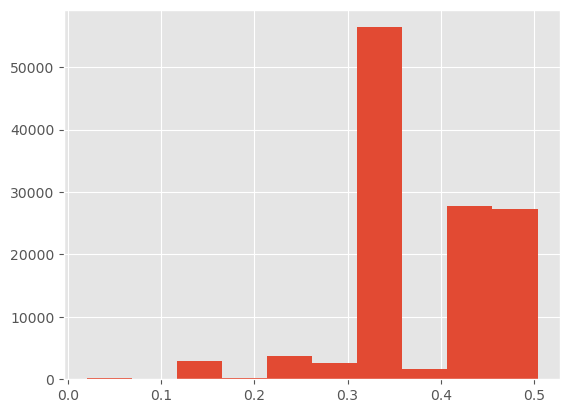

In [128]:
plt.style.use("ggplot")
plt.hist(network_cell_0["pvalue"])

In [129]:
adata.obsm["class_probs"].round(3)

array([[0.355, 0.   , 0.   , 0.407, 0.043, 0.196],
       [0.807, 0.039, 0.   , 0.034, 0.   , 0.121],
       [0.121, 0.04 , 0.   , 0.763, 0.   , 0.076],
       ...,
       [0.   , 0.   , 1.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 1.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 1.   , 0.   , 0.   , 0.   ]])

In [22]:
probs_1 = adata.obsm["class_probs"][1]
probs_1

array([0.80694622, 0.03857098, 0.        , 0.03385724, 0.        ,
       0.12062556])

In [ ]:
network_cell_1 = infer_cell_network(probs_1, classes, class_networks, alpha=0.25, default_alpha=(0.05 + 1)/2)

In [25]:
network_df_1 = infer_cell_network_df(probs_1, E, all_edges, alpha=0.25)

In [27]:
set(network_df_1.set_index([REG_VALS, TAR_VALS]).index) == set(network_cell_1.index)

True

In [ ]:
network_df_1

,regulator.values,target.values,log.p.values
0,ENSG00000001084,ENSG00000005844,-2.124576
1,ENSG00000001084,ENSG00000032444,-2.276555
2,ENSG00000001084,ENSG00000033627,-2.276555
3,ENSG00000001084,ENSG00000070961,-2.124576
4,ENSG00000001084,ENSG00000074370,-2.124576
...,...,...,...
34595,ENSG00000276043,ENSG00000216490,-2.124576
34596,ENSG00000276043,ENSG00000226742,-2.124576
34597,ENSG00000276043,ENSG00000237440,-2.124576
34598,ENSG00000276043,ENSG00000245848,-2.124576


In [138]:
pos_network_cell_1 = network_cell_1.pipe(lambda df: df[df["pvalue"] < 0.2])

In [139]:
pos_network_cell_1

pvalue  count      frac
regulator.values target.values                             
ENSG00000001084  ENSG00000005844  0.119484      1  0.806946
                 ENSG00000032444  0.102637      2  0.840803
                 ENSG00000033627  0.102637      2  0.840803
                 ENSG00000070961  0.119484      1  0.806946
                 ENSG00000074370  0.119484      1  0.806946
...                                    ...    ...       ...
ENSG00000276043  ENSG00000216490  0.119484      1  0.806946
                 ENSG00000226742  0.119484      1  0.806946
                 ENSG00000237440  0.119484      1  0.806946
                 ENSG00000245848  0.119484      1  0.806946
                 ENSG00000262246  0.119484      1  0.806946

[34600 rows x 3 columns]

(array([ 2276.,  3776., 28548.,     0.,     0.,     0.,     0.,     0.,
         2875., 77027.]),
 array([0.02059308, 0.06934913, 0.11810518, 0.16686124, 0.21561729,
        0.26437334, 0.3131294 , 0.36188545, 0.41064151, 0.45939756,
        0.50815361]),
 <BarContainer object of 10 artists>)

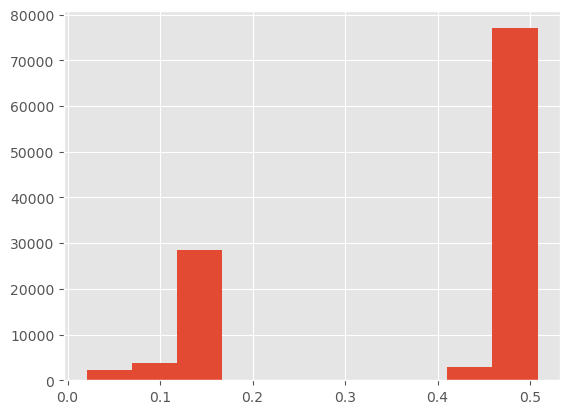

In [140]:
plt.hist(network_cell_1["pvalue"])

In [142]:
probs_5 = adata.obsm["class_probs"][5]
probs_5

array([0.52321033, 0.27817399, 0.        , 0.        , 0.        ,
       0.19861568])

In [143]:
network_cell_5 = infer_cell_network(probs_5, classes, class_networks, base_alpha=(0.05 + 1)/2)

In [144]:
network_cell_5

pvalue  count      frac
regulator.values target.values                             
ENSG00000001084  ENSG00000004399  0.423253      1  0.198616
                 ENSG00000005844  0.262070      1  0.523210
                 ENSG00000022267  0.380282      1  0.278174
                 ENSG00000023171  0.380282      1  0.278174
                 ENSG00000032444  0.262070      1  0.523210
...                                    ...    ...       ...
ENSG00000276043  ENSG00000245848  0.262070      1  0.523210
                 ENSG00000254470  0.380282      1  0.278174
                 ENSG00000261371  0.423253      1  0.198616
                 ENSG00000262246  0.262070      1  0.523210
                 ENSG00000273841  0.380282      1  0.278174

[85834 rows x 3 columns]

In [145]:
pos_network_cell_5 = network_cell_5.pipe(lambda df: df[df["pvalue"] < 0.2])

In [147]:
pos_network_cell_5.describe()

,pvalue,count,frac
count,3266.000000,3266.000000,3266.000000
mean,0.142649,2.031537,0.754715
std,0.030229,0.174791,0.057257
min,0.014281,2.000000,0.721826
25%,0.117352,2.000000,0.721826
50%,0.160323,2.000000,0.721826
75%,0.160323,2.000000,0.801384
max,0.160323,3.000000,1.000000


(array([  103.,     0.,   990.,  2173.,     0.,     0., 32326.,     0.,
        19876., 30366.]),
 array([0.01428133, 0.05517846, 0.0960756 , 0.13697273, 0.17786987,
        0.218767  , 0.25966414, 0.30056127, 0.34145841, 0.38235554,
        0.42325268]),
 <BarContainer object of 10 artists>)

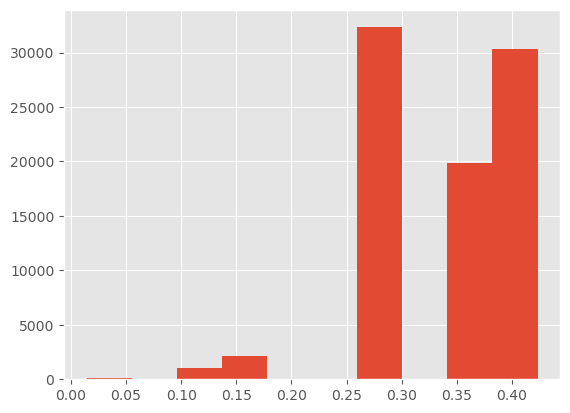

In [148]:
plt.hist(network_cell_5["pvalue"])

In [115]:
jaccard_index(set(pos_network_cell_5.index), set(class_networks['Macro_C1QC'].index))

0.09439306358381502

In [153]:
adata[[12],:].obs

,cell_type,cancer_type,batch,set,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,n_counts,sample_id,cluster
ACGATACGTGGCTCCA-10,Macro_C1QC,ESCA,10,query,315,5.755742,2710.154053,7.905129,0.0,0.0,0.0,2710.154053,0,4


In [154]:
classes

array(['Macro_C1QC', 'Macro_LYVE1', 'Macro_NLRP3', 'Mono_CD14',
       'Mono_CD16', 'cDC2_CD1C'], dtype=object)

In [164]:
probs_12 = adata.obsm["class_probs"][12]
probs_12

array([0.23626367, 0.        , 0.        , 0.72610092, 0.03763541,
       0.        ])

In [156]:
network_cell_12 = infer_cell_network(probs_12, classes, class_networks, base_alpha=(0.05 + 1)/2)

In [158]:
network_cell_12

pvalue  count      frac
regulator.values target.values                             
ENSG00000001084  ENSG00000005844  0.406270      1  0.236264
                 ENSG00000005961  0.163713      1  0.726101
                 ENSG00000006327  0.163713      1  0.726101
                 ENSG00000007237  0.163713      1  0.726101
                 ENSG00000008294  0.506103      1  0.037635
...                                    ...    ...       ...
ENSG00000276043  ENSG00000261371  0.506103      1  0.037635
                 ENSG00000262246  0.406270      1  0.236264
                 ENSG00000264364  0.163713      1  0.726101
                 ENSG00000271503  0.506103      1  0.037635
                 ENSG00000276070  0.506103      1  0.037635

[95015 rows x 3 columns]

In [ ]:
post_network_cell_12 = network_cell_12.pipe(lambda df: df[df["pvalue"] < 0.2])

In [163]:
post_network_cell_12

pvalue  count      frac
regulator.values target.values                             
ENSG00000001084  ENSG00000005961  0.163713      1  0.726101
                 ENSG00000006327  0.163713      1  0.726101
                 ENSG00000007237  0.163713      1  0.726101
                 ENSG00000032444  0.044983      2  0.962365
                 ENSG00000033627  0.044983      2  0.962365
...                                    ...    ...       ...
ENSG00000276043  ENSG00000196757  0.163713      1  0.726101
                 ENSG00000198131  0.163713      1  0.726101
                 ENSG00000204020  0.044983      2  0.962365
                 ENSG00000243927  0.163713      1  0.726101
                 ENSG00000264364  0.163713      1  0.726101

[34600 rows x 3 columns]

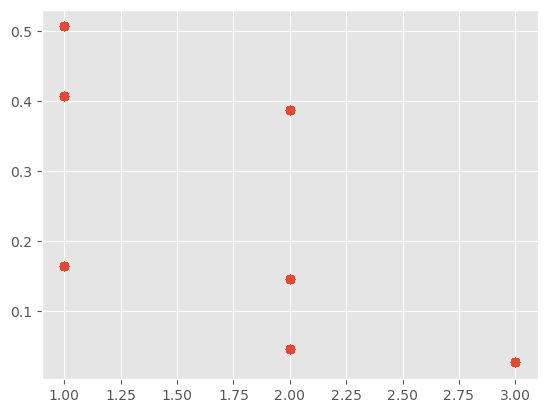

In [166]:
plt.scatter(network_cell_12["count"], network_cell_12["pvalue"] )

(array([ 3168.,     0., 31432.,     0.,     0.,     0.,     0., 31432.,
            0., 28983.]),
 array([0.02608622, 0.07408792, 0.12208961, 0.17009131, 0.218093  ,
        0.2660947 , 0.3140964 , 0.36209809, 0.41009979, 0.45810149,
        0.50610318]),
 <BarContainer object of 10 artists>)

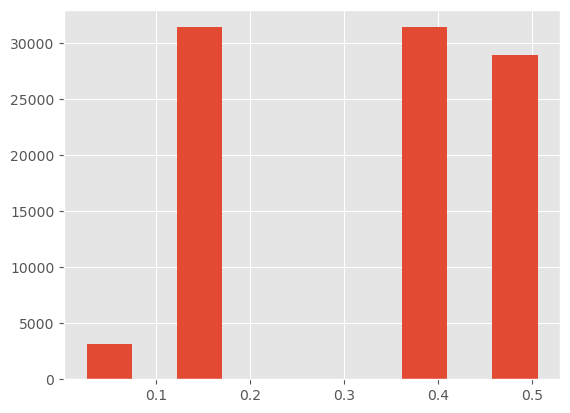

In [167]:
plt.hist(network_cell_12["pvalue"])